In [1]:
from utils.check_env import running_interactive
from collections import namedtuple
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

RUNNING_INTERACTIVE = running_interactive()

config = wandb.config if "WANDB_RUN_ID" in os.environ else {}

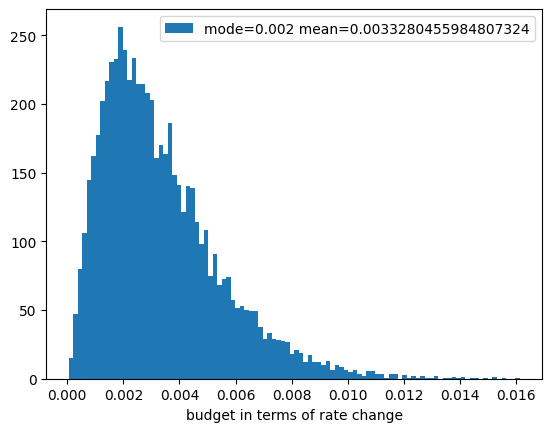

Sample Mode Approximation: 0.002
Actual Standard Deviation of Samples: 0.0021118726301776747


In [2]:
# plot budget curve
mode = 0.002

# Assuming some values for k (shape) and theta (scale) - these would need to be adjusted
k = 2.5  # Example shape parameter, needs fine-tuning
theta = mode / (k - 1)  # Approximate scale parameter based on mode formula

# Generate samples
samples = np.random.gamma(shape=k, scale=theta, size=10000)

# Plot histogram to visualize
plt.hist(samples, bins=100, density=True, label=f"mode={mode} mean={np.mean(samples)}")
plt.xlabel("budget in terms of rate change")
plt.legend()
plt.show()

# Calculate and print actual mode and standard deviation of the samples
print(f"Sample Mode Approximation: {mode}")  # Mode approximation based on input
actual_std = np.std(samples)
print(f"Actual Standard Deviation of Samples: {actual_std}")

In [3]:
# setup
Normal = namedtuple("Normal", ["mean", "std"])
Gamma = namedtuple("Gamma", ["k", "theta"])
num_blocks = 1000 if "num_blocks" not in config else int(config["num_blocks"])
rate = Normal(0.035, 0.02)
budget = Gamma(k, theta)
randseed = 0 if "randseed" not in config else int(config["randseed"])

In [4]:
# run shit
# fees = 0.005 if "fees" not in config else float(config["fees"])
rate_histories = []
records = []
min_fees = 0.0001
max_fees = 1
increment = 0.01
trades = 0
start_time = time.time()
debug = False
for fee_rate in np.arange(min_fees, max_fees + increment, increment):
# for fee_rate in [max_fees]:
    for epoch in range(100):
    # for epoch in range(1):
        rng = np.random.default_rng(seed=epoch)
        rate_history = [rate.mean]
        volume = 0
        trader_profit = 0
        lp_profit = 0
        for _ in range(1, num_blocks):
            # every trader has a different target rate
            target = rng.normal(rate.mean, rate.std)
            tradebudget = rng.gamma(budget.k, budget.theta)
            # trade if rate is outside of dead zone around their target
            diff_to_target = abs(rate_history[-1] - target)
            fees = rate_history[-1] * fee_rate
            if debug:
                print(f"{target=} {diff_to_target=} {fees=}")
            if diff_to_target > fees and tradebudget > fees:
                direction = -1 if target < rate_history[-1] else 1
                tradesize = max(0, min(diff_to_target, tradebudget))
                new_rate = rate_history[-1] + direction * tradesize
                rate_history.append(new_rate)
                rate_change = abs(rate_history[-1] - rate_history[-2])
                volume += rate_change
                trader_profit += rate_change - fees
                lp_profit += fees
                if debug:
                    print(f"{rate_change=} {fees=} {trader_profit=}")
                trades += 1
        records.append((fee_rate, epoch, trader_profit, lp_profit, volume))
        rate_histories.append(rate_history)
        if debug:
            plt.plot(rate_history)
print(f"simulated {trades=} trades in {time.time() - start_time} seconds")

simulated trades=892716 trades in 37.84798502922058 seconds


In [5]:
# create dataframe
if RUNNING_INTERACTIVE:
    rh_df = pd.DataFrame(rate_histories)
    results = pd.DataFrame(records, columns=["fee_rate", "epoch", "trader_profit", "lp_profit", "volume"])
    results["happiness"] = results["lp_profit"] + results["trader_profit"] * 0.5
    display(results)

,fee_rate,epoch,trader_profit,lp_profit,volume,happiness
0,0.0001,0,3.142259,0.003329,3.145587,1.574458
1,0.0001,1,3.071405,0.003447,3.074852,1.539150
2,0.0001,2,3.011830,0.003498,3.015329,1.509413
3,0.0001,3,3.117038,0.003567,3.120605,1.562086
4,0.0001,4,3.079975,0.003596,3.083571,1.543584
...,...,...,...,...,...,...
10095,1.0001,95,0.000000,0.000000,0.000000,0.000000
10096,1.0001,96,0.000000,0.000000,0.000000,0.000000
10097,1.0001,97,0.000000,0.000000,0.000000,0.000000
10098,1.0001,98,0.000000,0.000000,0.000000,0.000000


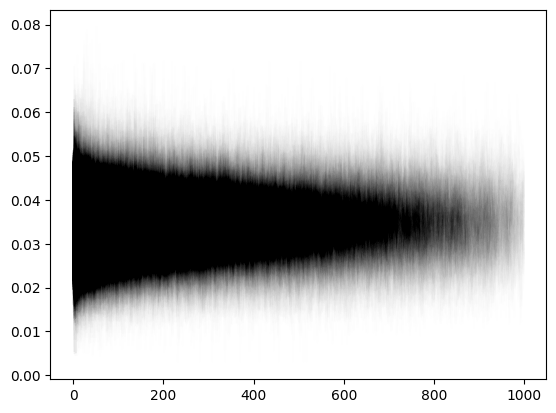

In [6]:
# rate history
if RUNNING_INTERACTIVE:
    plt.plot(rh_df.values.T, alpha=0.005, color="black")
    plt.show()  

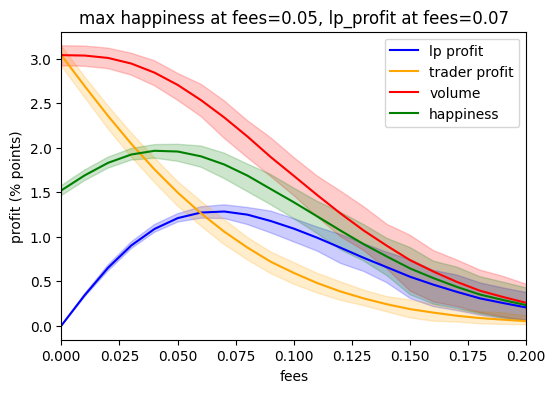

In [7]:
# plot together
if RUNNING_INTERACTIVE:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    sns.lineplot(x="fee_rate", y="lp_profit", data=results, color="blue", ax=ax, label="lp profit", errorbar="pi")
    sns.lineplot(x="fee_rate", y="trader_profit", data=results, color="orange", ax=ax, label="trader profit", errorbar="pi")
    sns.lineplot(x="fee_rate", y="volume", data=results, color="red", ax=ax, label="volume", errorbar="pi")
    sns.lineplot(x="fee_rate", y="happiness", data=results, color="green", ax=ax, label="happiness", errorbar="pi")
    plt.xlim([0, 0.2])
    plt.xlabel("fees")
    plt.ylabel("profit (% points)")
    # find index where happiness is max
    max_happiness = np.round(results['fee_rate'][results["happiness"].idxmax()], 2)
    max_lp_profit = np.round(results['fee_rate'][results["lp_profit"].idxmax()], 2)
    plt.title(f"max happiness at fees={max_happiness}, lp_profit at fees={max_lp_profit}")
    plt.legend();